In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import NNConv
from torch_geometric.loader import DataLoader
import numpy as np
import random
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from torch.nn import Sequential, Linear
from sklearn.preprocessing import StandardScaler


C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:85: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 指定されたプロシージャが見つかりません。
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:123: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] 指定されたプロシージャが見つかりません。
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the s

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)


Using device: cuda


In [3]:
# Set seeds for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)


In [4]:
# Parameters
num_nodes = 100
anchors = 25
unknowns = num_nodes - anchors
communication_range = 14.5  # Adjust as needed
num_measurements = 100

# Datasets
num_train_graphs = 1000  # Number of graphs for training
num_test_graphs = 20    # Number of graphs for testing


In [5]:
# Generate fixed anchor positions
fixed_anchor_positions = [[random.uniform(i[0], i[1]), random.uniform(j[0], j[1])]
                          for i in [[0, 2], [2, 4], [4, 6], [6, 8], [8, 10]]
                          for j in [[0, 2], [2, 4], [4, 6], [6, 8], [8, 10]]]
fixed_anchor_positions = np.array(fixed_anchor_positions)


In [6]:
def generate_random_graph_fixed_anchors(seed=None, num_measurements=10, anchor_positions=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        
    if anchor_positions is None:
        raise ValueError("Anchor positions must be provided.")
    
    anchor_positions = np.array(anchor_positions)
    num_anchors = anchor_positions.shape[0]
    assert num_anchors == anchors, "Number of anchors does not match the provided anchor positions."
    
    # Generate random positions for unknown nodes
    unknown_positions = np.random.uniform(0, 10, size=(unknowns, 2))
    truth_location_list = np.vstack([anchor_positions, unknown_positions])
    
    # Initial estimates (unknown nodes can have random initial positions)
    estimate_location_list = np.zeros((num_nodes, 2))
    estimate_location_list[:anchors] = truth_location_list[:anchors]  # Anchors know their positions
    estimate_location_list[anchors:] = np.random.uniform(0, 10, size=(unknowns, 2))
    
    # Build the graph (same as before)
    tree = KDTree(truth_location_list)
    edges = tree.query_pairs(r=communication_range)
    edges = list(edges)
    edge_index = np.array(edges + [(j, i) for (i, j) in edges]).T
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    
    # Generate edge attributes (same as before)
    num_edges = edge_index.shape[1]
    edge_attr_list = []
    for i in range(num_edges):
        src = edge_index[0, i].item()
        dst = edge_index[1, i].item()
        distance = np.linalg.norm(truth_location_list[src] - truth_location_list[dst])
        rssi_measurements = -17.2 * np.log10(distance * 1000) - 62.4 + np.random.normal(0, 3, num_measurements)
        noisy_distances = 10 ** ((rssi_measurements + 62.4) / -17.2) / 1000
        edge_attr_list.append(noisy_distances)
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
    
    # Compute node features
    x = compute_node_features(truth_location_list, estimate_location_list, edge_index, edge_attr)
    
    # Labels and masks
    y = torch.tensor(truth_location_list, dtype=torch.float)
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:anchors] = True
    unknown_mask = ~anchor_mask
    
    # Create data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask
    
    return data


In [7]:
def compute_node_features(truth_location_list, estimate_location_list, edge_index, edge_attr):
    node_features = []
    num_nodes = truth_location_list.shape[0]
    for idx in range(num_nodes):
        is_anchor = idx < anchors
        # Node degree
        degree = (edge_index[0] == idx).sum().item()
        if is_anchor:
            # Anchors: Use known positions and degree
            feature = np.hstack([truth_location_list[idx], degree, 1])  # 1 indicates anchor
        else:
            # Unknown nodes: Use estimated distances to neighboring anchors
            neighbor_indices = edge_index[1][edge_index[0] == idx].numpy()
            neighbor_anchors = neighbor_indices[neighbor_indices < anchors]
            neighbor_edge_indices = np.where(
                (edge_index[0].numpy() == idx) & (edge_index[1].numpy() < anchors)
            )[0]
            if len(neighbor_edge_indices) > 0:
                distances = edge_attr[neighbor_edge_indices].numpy().flatten()
                # Feature: Mean and std of estimated distances
                mean_dist = np.mean(distances)
                std_dist = np.std(distances)
                feature = np.array([mean_dist, std_dist, degree, 0])  # 0 indicates unknown node
            else:
                feature = np.array([0.0, 0.0, degree, 0])
        node_features.append(feature)
    x = torch.tensor(node_features, dtype=torch.float)
    return x


In [8]:
# Generate training data with fixed anchors
train_data_list = [generate_random_graph_fixed_anchors(seed=i, num_measurements=num_measurements, anchor_positions=fixed_anchor_positions) for i in range(num_train_graphs)]

# Generate test data with fixed anchors
test_data_list = [generate_random_graph_fixed_anchors(seed=1000 + i, num_measurements=num_measurements, anchor_positions=fixed_anchor_positions) for i in range(num_test_graphs)]

C:\Users\kazuya\AppData\Local\Temp\ipykernel_37544\2998020359.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)


In [9]:
# Collect all node features for scaling
all_features = torch.cat([data.x for data in train_data_list], dim=0).numpy()
scaler = StandardScaler()
scaler.fit(all_features)

# Normalize features in training and test data
for data in train_data_list + test_data_list:
    data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)


In [10]:
from torch_geometric.loader import DataLoader

# Create data loaders
train_loader = DataLoader(train_data_list, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=1, shuffle=False)


In [11]:
class EdgeFeatureNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EdgeFeatureNet, self).__init__()
        self.net = Sequential(
            Linear(input_dim, 64),
            torch.nn.ReLU(),
            Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, edge_feature_dim, num_measurements):
        super(GCN, self).__init__()
        # Edge feature network to process time-series edge attributes
        self.edge_net = EdgeFeatureNet(num_measurements, edge_feature_dim)
        
        # Edge networks for NNConv layers
        nn1 = Sequential(Linear(edge_feature_dim, hidden_dim * input_dim))
        self.conv1 = NNConv(input_dim, hidden_dim, nn1, aggr='mean')
        
        nn2 = Sequential(Linear(edge_feature_dim, hidden_dim * hidden_dim))
        self.conv2 = NNConv(hidden_dim, hidden_dim, nn2, aggr='mean')
        
        self.fc = Linear(hidden_dim, output_dim)
        
        # Projection layers for anchor nodes
        self.anchor_proj1 = Linear(input_dim, hidden_dim)
        self.anchor_proj2 = Linear(hidden_dim, hidden_dim)
    
    def forward(self, x, edge_index, edge_attr, anchor_mask):
        # Process edge attributes using EdgeFeatureNet
        edge_attr_processed = self.edge_net(edge_attr)
        
        # Save the original features of anchor nodes
        x_anchor = x[anchor_mask]
        
        # First GNN layer
        x = self.conv1(x, edge_index, edge_attr_processed)
        x = F.relu(x)
        
        # Project anchor nodes' features to match the hidden dimension
        x_anchor_proj = self.anchor_proj1(x_anchor)
        
        # Create a full-sized tensor for x_anchor_proj
        x_anchor_proj_full = x.clone()
        x_anchor_proj_full[anchor_mask] = x_anchor_proj
        
        # Combine the projected anchor features with the updated features
        x = torch.where(anchor_mask.unsqueeze(1), x_anchor_proj_full, x)
        
        # Save the features of anchor nodes after the first layer
        x_anchor = x[anchor_mask]
        
        # Second GNN layer
        x = self.conv2(x, edge_index, edge_attr_processed)
        x = F.relu(x)
        
        # Project anchor nodes' features to match the hidden dimension
        x_anchor_proj = self.anchor_proj2(x_anchor)
        
        # Create a full-sized tensor for x_anchor_proj
        x_anchor_proj_full = x.clone()
        x_anchor_proj_full[anchor_mask] = x_anchor_proj
        
        # Combine the anchor features with the updated features
        x = torch.where(anchor_mask.unsqueeze(1), x_anchor_proj_full, x)
        
        # Final fully connected layer
        x = self.fc(x)
        return x

In [35]:
input_dim = train_data_list[0].x.shape[1]  # Adjust input dimension based on node features
hidden_dim = 64  # You can adjust this
output_dim = 2   # Predicting x and y coordinates
edge_feature_dim = 32  # Adjust as needed

# Instantiate model and optimizer
model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, edge_feature_dim=edge_feature_dim, num_measurements=num_measurements).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [36]:
# Training loop
model.train()
loss_history = []

for epoch in range(100):
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)

        # Compute loss only for unknown nodes
        loss = F.mse_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')


Epoch 0, Loss: 6.4513
Epoch 10, Loss: 0.0220
Epoch 20, Loss: 0.0175
Epoch 30, Loss: 0.0144
Epoch 40, Loss: 0.0121
Epoch 50, Loss: 0.0101
Epoch 60, Loss: 0.0103
Epoch 70, Loss: 0.0107
Epoch 80, Loss: 0.0106
Epoch 90, Loss: 11.0247


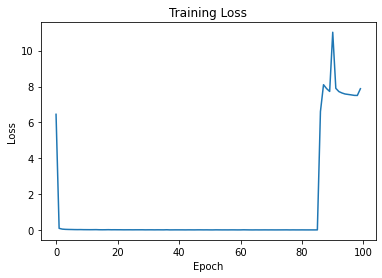

In [37]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [38]:
import copy
import scipy.optimize as opt
def multilateration_method(data):
    # Extract data
    truth_location_list = data.y.numpy()
    estimated_accuracy_list = np.array([1] * anchors + [0] * unknowns)
    estimate_location_list = np.zeros((num_nodes, 2))
    estimate_location_list[:anchors] = truth_location_list[:anchors]
    estimate_location_list[anchors:] = np.random.uniform(0, 10, size=(unknowns, 2))
    
    # Initialize history data structure
    neighbor_history = {i: {} for i in range(num_nodes)}
    max_iterations = 10
    
    for iteration in range(max_iterations):
        estimate_location_list_old = copy.deepcopy(estimate_location_list)
        estimated_accuracy_list_old = copy.deepcopy(estimated_accuracy_list)
        for idx in range(num_nodes):
            if estimated_accuracy_list_old[idx] == 1:
                continue  # Skip anchors
            neighbor_list = []
            # Find neighbors
            neighbor_indices = data.edge_index[1][data.edge_index[0] == idx].numpy()
            neighbor_indices = np.unique(neighbor_indices)
            for neighbor_idx in neighbor_indices:
                if estimated_accuracy_list_old[neighbor_idx] >= 0.25:
                    # Use neighbor's estimated location and compute distance
                    neighbor_loc = estimate_location_list[neighbor_idx]
                    distance = np.linalg.norm(truth_location_list[idx] - truth_location_list[neighbor_idx])
                    # Simulate RSSI with noise
                    rssi = -17.2 * np.log10(distance*1000) - 62.4 + np.random.normal(0, 3)
                    noisy_distance = 10**((rssi + 62.4)/-17.2)/1000
                    # Update history data
                    if neighbor_idx not in neighbor_history[idx]:
                        neighbor_history[idx][neighbor_idx] = []
                    neighbor_history[idx][neighbor_idx].append(noisy_distance)
                    # Use average of historical distances
                    avg_noisy_distance = np.mean(neighbor_history[idx][neighbor_idx])
                    neighbor_list.append((neighbor_loc, avg_noisy_distance))
            # Perform multilateration
            if len(neighbor_list) >= 3:
                def error_function(x):
                    return sum((np.linalg.norm(x - np.array(neighbor[0])) - neighbor[1])**2 for neighbor in neighbor_list)
                initial_guess = np.mean([neighbor[0] for neighbor in neighbor_list], axis=0)
                result = opt.minimize(error_function, initial_guess)
                if result.success:
                    estimate_location_list[idx] = result.x
                    estimated_accuracy_list[idx] = 1 - np.sqrt(result.fun / len(neighbor_list))/np.mean([neighbor[1] for neighbor in neighbor_list])
        # Check for convergence (optional)
        if np.allclose(estimate_location_list, estimate_location_list_old, atol=1e-2):
            break  # Converged
    
    # Compute errors for unknown nodes
    errors = np.linalg.norm(estimate_location_list[anchors:] - truth_location_list[anchors:], axis=1)
    return errors


In [39]:
model.eval()
errors_gcn = []
errors_multilateration = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)  # Move data to device
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)
        predicted_positions = out.cpu().numpy()  # Move predictions back to CPU for numpy operations
        true_positions = data.y.cpu().numpy()    # Move true positions back to CPU

        # Overwrite anchor nodes' positions with true positions
        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        # Calculate estimation errors for unknown nodes
        error = np.linalg.norm(predicted_positions[data.unknown_mask.cpu()] - true_positions[data.unknown_mask.cpu()], axis=1)
        errors_gcn.extend(error)
        
        # Multilateration method errors
        error_multi = multilateration_method(data.cpu())  # Move data back to CPU if needed
        errors_multilateration.extend(error_multi)


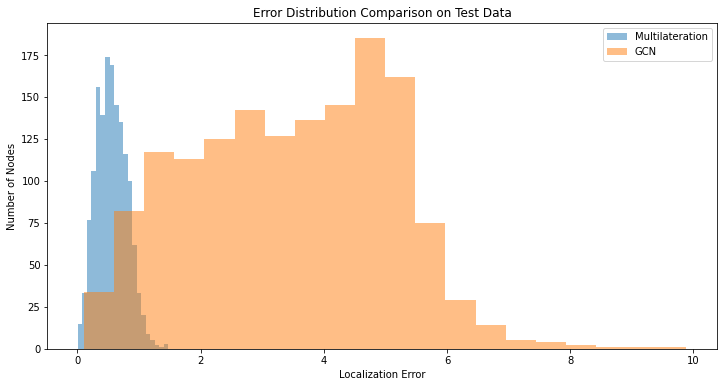

Multilateration Mean Error: 0.5570, Median Error: 0.5458
GCN Mean Error: 3.4782, Median Error: 3.5673


In [40]:
# Convert errors to numpy arrays
errors_gcn = np.array(errors_gcn)
errors_multilateration = np.array(errors_multilateration)

# Plot error distributions
plt.figure(figsize=(12, 6), facecolor='white')

plt.hist(errors_multilateration, bins=20, alpha=0.5, label='Multilateration')
plt.hist(errors_gcn, bins=20, alpha=0.5, label='GCN')
plt.xlabel('Localization Error')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution Comparison on Test Data')
plt.legend()
plt.show()

# Print mean and median errors
print(f"Multilateration Mean Error: {errors_multilateration.mean():.4f}, Median Error: {np.median(errors_multilateration):.4f}")
print(f"GCN Mean Error: {errors_gcn.mean():.4f}, Median Error: {np.median(errors_gcn):.4f}")


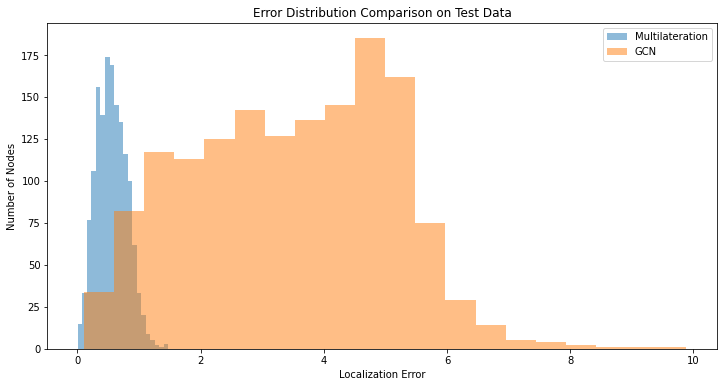

Multilateration Mean Error: 0.5570, Median Error: 0.5458
GCN Mean Error: 3.4782, Median Error: 3.5673


In [41]:
# Convert errors to numpy arrays
errors_gcn = np.array(errors_gcn)
errors_multilateration = np.array(errors_multilateration)

# Plot error distributions
plt.figure(figsize=(12, 6), facecolor='white')

plt.hist(errors_multilateration, bins=20, alpha=0.5, label='Multilateration')
plt.hist(errors_gcn, bins=20, alpha=0.5, label='GCN')
plt.xlabel('Localization Error')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution Comparison on Test Data')
plt.legend()
plt.show()

# Print mean and median errors
print(f"Multilateration Mean Error: {errors_multilateration.mean():.4f}, Median Error: {np.median(errors_multilateration):.4f}")
print(f"GCN Mean Error: {errors_gcn.mean():.4f}, Median Error: {np.median(errors_gcn):.4f}")


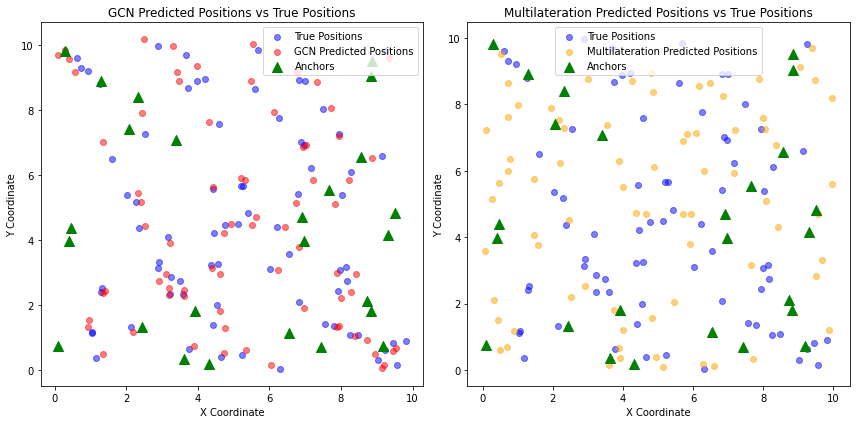

In [36]:
# Get a sample test graph
sample_data = test_data_list[0]
sample_data = sample_data.to(device)

# GCN predictions
model.eval()
with torch.no_grad():
    out = model(sample_data.x, sample_data.edge_index, sample_data.edge_attr, sample_data.anchor_mask)
    predicted_positions = out.cpu().numpy()
    true_positions = sample_data.y.cpu().numpy()

# Multilateration predictions
estimate_location_list = np.zeros((num_nodes, 2))
estimate_location_list[:anchors] = true_positions[:anchors]
estimate_location_list[anchors:] = np.random.uniform(0, 10, size=(unknowns, 2))
errors_multi = multilateration_method(sample_data.cpu())
multi_predicted_positions = estimate_location_list

# Plotting
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('GCN Predicted Positions vs True Positions')
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0], true_positions[sample_data.unknown_mask.cpu(),1], c='blue', label='True Positions', alpha=0.5)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0], predicted_positions[sample_data.unknown_mask.cpu(),1], c='red', label='GCN Predicted Positions', alpha=0.5)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0], true_positions[sample_data.anchor_mask.cpu(),1], c='green', label='Anchors', marker='^', s=100)
plt.legend()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.subplot(1,2,2)
plt.title('Multilateration Predicted Positions vs True Positions')
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0], true_positions[sample_data.unknown_mask.cpu(),1], c='blue', label='True Positions', alpha=0.5)
plt.scatter(multi_predicted_positions[sample_data.unknown_mask,0], multi_predicted_positions[sample_data.unknown_mask,1], c='orange', label='Multilateration Predicted Positions', alpha=0.5)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0], true_positions[sample_data.anchor_mask.cpu(),1], c='green', label='Anchors', marker='^', s=100)
plt.legend()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.tight_layout()
plt.show()
